# Segment Anything in Medical Images
Segmentation is a fundamental task in medical imaging analysis. Deep learning-based models have shown great promise in medical image segmentation due to their ability to learn intricate image features and deliver accurate segmentation results across a diverse range of tasks. Recently, the Segmentation Anything Model (SAM) has shown remarkable versatility and performance in natural image segmentation. However, their application to medical image segmentation has been challenging due to the substantial domain gap.

## Overview

0. Installation
1. Methodology introduction
2. Load pre-trained model
3. Load data and run inference in an interactive way
4. **Others (Plan for our modifications)**
   - a. Replace segmentation loss with object detection loss and refine for object detection: to detect left and right kidneys 
   - b. Train the object detection model
   - c. Evaluate the performance with standard object detection metrics such as Intersection over Union (IoU), Mean Average Precision (mAP)
   - d. Modify the Unet to do the same thing and compare the results.

## Installation is super easy. 
On the local device:
- Create a fresh environment `conda create -n medsam python=3.10 -y` and activate it `conda activate medsam`
- Install [pytorch 2.0](https://pytorch.org/get-started/locally/)
- Run the following command.

If you are using Colab, you can directly run the following command. 

In [1]:
#!pip install git+https://github.com/bowang-lab/MedSAM.git

## 1. Methodology introduction

SAM is a promptable segmentation model and it supports three types of prompts: bounding box, point, and text. (Note: The text-prompt function in SAM is not publicly available.) While the concept of fully automatic medical image segmentation foundation models is enticing, it is fraught with challenges that make it impractical. One of the primary challenges is the variability inherent in segmentation tasks. For example, given a liver cancer CT image, the segmentation task can vary depending on the specific clinical scenario. One clinician might be interested in segmenting the liver tumor, while another might need to segment the entire liver and surrounding organs. Additionally, the variability in imaging modalities presents another challenge. Modalities such as CT and MR generate 3D images, whereas others like X-Ray and ultrasound yield 2D images. These variabilities in task definition and imaging modalities complicate the design of a fully automatic model capable of accurately anticipating and addressing the diverse requirements of different users.

Considering these challenges, we argue that a more practical approach is to develop a promptable 2D model for general medical image segmentation. The model can be easily adapted to specific tasks based on user-provided prompts, offering enhanced flexibility and adaptability. It is also able to handle both 2D and 3D images by processing 3D images as a series of 2D slices. Compared to point-based and text-based prompts, the bounding box-based prompt has three main advantages: 1) it has less ambiguity and can clearly specify the ROI with minor user intervention (clicking on the top left and bottom right points); 2) it doesn't require multiple trial and error; 3) it can be seamlessly integrated into tumor measurements (e.g., Response Evaluation Criteria In Solid Tumors [RECIST](https://radiologyassistant.nl/more/recist-1-1/recist-1-1)) by simulating bounding box from the linear annotation (e.g., long axis and short axis).  


In order to use the pre-trained weights, we follow SAM's network architecture in SAM, including an image encoder, a prompt encoder, and a mask decoder. The image encoder maps the input image into a high-dimensional image embedding space. The prompt encoder transforms the user-drawn bounding boxes into feature representations via positional encoding. Finally, the mask decoder fuses the image embedding and prompt features using cross-attention. It should be noted that the image embedding only needs to be computed once during inference. Then, one can draw different bounding boxes to segment different targets in real-time. 

![network](assets/architecture.png)

## 2. Load pre-trained model

Please download the checkpoint [here](https://drive.google.com/drive/folders/1ETWmi4AiniJeWOt6HAsYgTjYv_fkgzoN?usp=drive_link). This pre-trained model can be directed loaded with SAM's checkpoint loader. 

In [3]:
%matplotlib widget
from segment_anything import sam_model_registry
from utils.demo import BboxPromptDemo
MedSAM_CKPT_PATH = "./checkpoint/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
  

## 3. Load data and run inference in an interactive way

One can directly draw the bounding box to segment the targets. Here are two examples of the abdomen CT image and colon gland pathology image. 
Please use relatively tight bounding boxes since the model was not trained with large bounding box perturbations. 

![abdomen CT](assets/seg_demo.gif)

Button(description='clear', style=ButtonStyle())

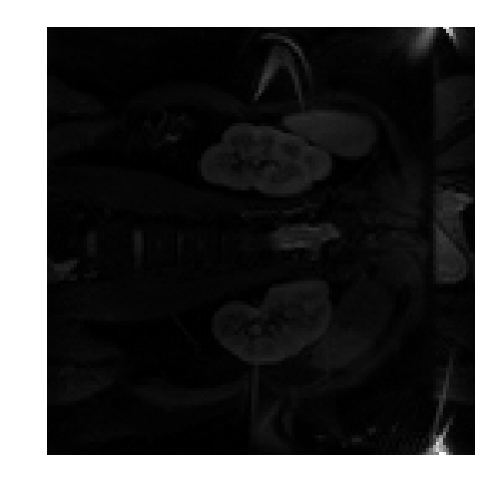

Button(description='save', style=ButtonStyle())

In [5]:
# abdomen CT
img = "./data/sample_image.png"
bbox_prompt_demo = BboxPromptDemo(medsam_model)
bbox_prompt_demo.show(img)

## 4. Others
We will do the following next:
- a. Replace segmentation loss with object detection loss and refine for object detection: to detect left and right kidneys 
- b. Train the object detection model
- c. Evaluate the performance with standard object detection metrics such as Intersection over Union (IoU), Mean Average Precision (mAP)
- d. Modify the Unet to do the same thing and compare the results.